# Capstone Project for the Data Science Specialization

### Rafael Y. Imai - April 2021

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
dados = pd.read_csv("/CVMData/inf_diario_fi_201701.csv", sep = ";")

In [9]:
cadFundos = pd.read_excel("cad_fi.xlsx")

In [6]:
cadFundos.shape

(60378, 39)

In [10]:
dados.head()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,00.017.024/0001-53,2017-01-02,1082310.35,24.264751,1080998.58,0.0,0.0,1
1,00.017.024/0001-53,2017-01-03,1082843.72,24.274863,1081449.09,0.0,0.0,1
2,00.017.024/0001-53,2017-01-04,1083398.28,24.284681,1081886.49,0.0,0.0,1
3,00.017.024/0001-53,2017-01-05,1083940.08,24.294975,1082345.09,0.0,0.0,1
4,00.017.024/0001-53,2017-01-06,1084174.96,24.304952,1082789.54,0.0,0.0,1


In [12]:
cnpjTopFIC = "14.188.162/0001-00"

dadosTopFIC2017 = dados[dados["CNPJ_FUNDO"]==cnpjTopFIC]

dadosTopFIC2017.head()

,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
149950,14.188.162/0001-00,2017-01-02,4.221649e+08,1.730198,4.222229e+08,1175134.40,442686.20,7335
149951,14.188.162/0001-00,2017-01-03,4.231282e+08,1.731117,4.237659e+08,1318949.54,0.00,7367
149952,14.188.162/0001-00,2017-01-04,4.250626e+08,1.732094,4.253207e+08,1666065.52,350471.32,7391
149953,14.188.162/0001-00,2017-01-05,4.218143e+08,1.732949,4.273475e+08,2087038.11,270304.86,7430
149954,14.188.162/0001-00,2017-01-06,4.232264e+08,1.733936,4.292862e+08,1781051.26,85748.56,7452


In [13]:
dadosRefinados = dadosTopFIC2017[["DT_COMPTC", "VL_QUOTA"]]
dadosRefinados.head()

,DT_COMPTC,VL_QUOTA
149950,2017-01-02,1.730198
149951,2017-01-03,1.731117
149952,2017-01-04,1.732094
149953,2017-01-05,1.732949
149954,2017-01-06,1.733936


<AxesSubplot:xlabel='DT_COMPTC'>

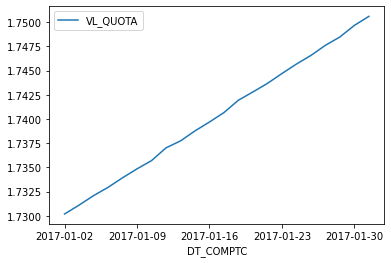

In [16]:
dadosRefinados.plot(x="DT_COMPTC", y="VL_QUOTA")